# Import of the libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras import Model
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator


from keras.models import load_model

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import of the dataset

In order to import the dataset directly from kaggle we have to create **and** import the kaggle.json key first

In [ ]:
!pip -qq install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

I will use the brain tumor classification dataset for the fine-tuning

In [ ]:
!kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection

 99% 15.0M/15.1M [00:00<00:00, 25.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 15.9MB/s]


In [ ]:
!unzip -qq brain-mri-images-for-brain-tumor-detection.zip

# Dataset creation

In [ ]:
# Set the path to the directory containing the images
data_dir = '/content'

# Get a list of all the image filenames in the directories
yes_files = os.listdir(os.path.join(data_dir, 'yes'))
no_files = os.listdir(os.path.join(data_dir, 'no'))

# Create a list of dictionaries, where each dictionary contains the image filename, its path, and its label
data_list = []
for filename in yes_files:
    data_list.append({'path': os.path.join(data_dir, 'yes', filename), 'label': 'yes'})
for filename in no_files:
    data_list.append({'path': os.path.join(data_dir, 'no', filename), 'label': 'no'})

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list).sample(frac=1, random_state=42)

df.head()

,path,label
208,/content/no/46 no.jpg,no
6,/content/yes/Y4.jpg,yes
79,/content/yes/Y34.jpg,yes
204,/content/no/N16.jpg,no
117,/content/yes/Y168.jpg,yes


In [ ]:
train_df=df[:200]
val_df=df[200:253]

In [ ]:
datagen = ImageDataGenerator()

train_ds = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary'
)

val_ds = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary'
)

Found 200 validated image filenames belonging to 2 classes.
Found 53 validated image filenames belonging to 2 classes.


# Fine Tuning

For the task I fine tuned ResNet50 on the new dataset


In [ ]:
# load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add new classification layer
# After many trials we obtained the best results with this classification head
base = base_model.output
gp = GlobalAveragePooling2D()(base)
dense_1 = Dense(1024, activation='relu')(gp)
dense_2 = Dense(512, activation='relu')(dense_1)
predictions = Dense(1, activation='sigmoid')(dense_2)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

# freeze ResNet50 layers to prevent re-training
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
]

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
model.fit(train_ds, epochs=15,
          callbacks=my_callbacks, 
          validation_data=val_ds)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 [==============================] - 9s 76ms/step - loss: 0.9637 - binary_accuracy: 0.6700 - val_loss: 0.5306 - val_binary_accuracy: 0.7170
Epoch 2/15
50/50 [==============================] - 2s 49ms/step - loss: 0.2996 - binary_accuracy: 0.8750 - val_loss: 0.3321 - val_binary_accuracy: 0.8868
Epoch 3/15
50/50 [==============================] - 3s 55ms/step - loss: 0.2317 - binary_accuracy: 0.8950 - val_loss: 0.6761 - val_binary_accuracy: 0.7547
Epoch 4/15
50/50 [==============================] - 3s 54ms/step - loss: 0.1449 - binary_accuracy: 0.9350 - val_loss: 0.4143 - val_binary_accuracy: 0.8868
Epoch 5/15
50/50 [==============================] - 2s 32ms/step - loss: 0.0946 - binary_accuracy: 0.9600 - val_loss: 0.3775 - val_binary_accuracy: 0.9245


# Save the model

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
#model.save('/content/drive/MyDrive/ML4CV_models/brain_binary.h5')

# Grad-CAM

## Import of the model

The model has been already fine tuned on Brain Tumore classification and can be loaded throught the following commands

In [ ]:
!gdown 1TMSBaroQmTO3L9l8tiDHEkSfjN8mrw8K

Downloading...
From: https://drive.google.com/uc?id=1TMSBaroQmTO3L9l8tiDHEkSfjN8mrw8K
To: /content/brain_binary.h5
100% 126M/126M [00:01<00:00, 103MB/s]


In [ ]:
model_path='/content/brain_binary.h5'

In [ ]:
model = load_model(model_path)

In [ ]:
#model.summary()

You can apply Grad-CAM on any CNN as long as it has been implemented using keras.

For this experiment we will use a model for binary classification but feel free to speriment with different tasks

## Grad-CAM application

In [ ]:
!gdown 1Ws4BUtOelM-E3X-BqTDejN3LzBU0AMtK

Downloading...
From: https://drive.google.com/uc?id=1Ws4BUtOelM-E3X-BqTDejN3LzBU0AMtK
To: /content/brain_center.jpeg
100% 26.8k/26.8k [00:00<00:00, 54.8MB/s]


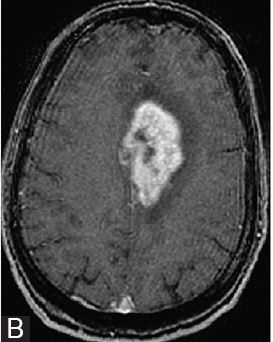

In [ ]:
img_path = 'brain_center.jpeg'

display(Image(img_path))

In [ ]:
preprocess_input = keras.applications.resnet50.preprocess_input

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

The following configuration is ad hoc for our model:


* **img_size** ->  depends on the size of the images with which the model was trained (e.g. (224,224) for ResNet50)
* **last_conv_layer_name** -> depends on the architecture of the model, you can find the name of the last convolutional layer of you model looking into the `model.summary()`
* **pred_index** -> specify the class I want the explanation of. In our case, since it's a binary classification we can only have 0 but with more classes you can specify it. By default it will be set to the majority class evaluated by the model.
This index can be usefull if we have more subjects in the same image, for example if we have a dog and a cat in the same image we can create the heatmap w.r.t to the dog class or w.r.t the cat class






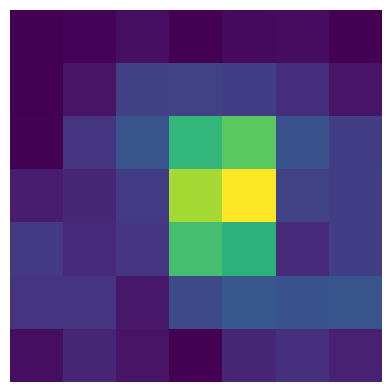

In [ ]:
# Prepare image
img_size = (224, 224)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
last_conv_layer_name = "conv5_block3_out"

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=0)

# Display heatmap
plt.matshow(heatmap)
plt.axis('off')
plt.show()

Finally we combine the initial image with the heatmap in order to have a more comprehensive visual explanation

* `alpha` is a parameter that controls the blending of the heatmap with the original image during the superimposition process. The higher is alpha the higher will be the contrast.



<ipython-input-55-da88a0bc1c6e>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


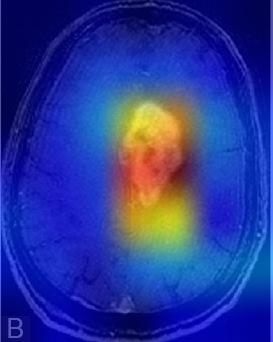

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=2):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# Conclusion

As we can see the results are satisfactory and Grad-CAM has shown really good localization ability.

Another interesting thing we noticed is that the same technique applied to a model with a lower perfomance (80% of accuracy instead of 92% on validation set) has way worse perfomances. 

From this we can infer that achieving high performance models is crucial for accurate tumor localization and that the there is a strong dependence between the model ability of the technique and the perfomances of the model